# Comida/No Comida Text Classification

## 1. Import necessary libraries

In [ ]:
# Install dependecies (this is mostly for Google Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio
  import datasets, evaluate, accelerate
  import gradio as gr

import random
import numpy as np
import pandas as pd
import torch
import transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
print(f"Using transfomers version: {transformers.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using datasets version: {datasets.__version__}")

Using transfomers version: 4.48.3
Using torch version: 2.5.1+cu124
Using datasets version: 3.3.1


## 2. Getting a dataset

We are using the dataset ["comida_no_comida"](https://huggingface.co/datasets/Sairii/comida_no_comida) from Hugging Face.

It consists in ~1000 text phrases labeled `comida` and `no_comida`.

In [ ]:
from datasets import load_dataset

dataset= load_dataset("Sairii/comida_no_comida")
dataset

README.md:   0%|          | 0.00/302 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/34.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1034
    })
})

In [ ]:
# What features are there?
dataset.column_names

{'train': ['text', 'label']}

In [ ]:
# Access the training split
dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 1034
})

In [ ]:
dataset["train"][0]

{'text': 'La pasta es el abrazo que necesitas después de un día largo.',
 'label': 'comida'}

### Inspect random samples

In [ ]:
import random

random_indexes = random.sample(range(len(dataset["train"])),5)
print(random_indexes)

random_samples = dataset["train"][random_indexes]
random_samples

print(f"[INFO] Random samples from dataset:\n")
for text, label in zip(random_samples["text"], random_samples["label"]):
  print(f"Text: {text} | Label: {label}")

[832, 608, 294, 300, 636]
[INFO] Random samples from dataset:

Text: Los rolls de pepino son la opción refrescante del sushi. | Label: comida
Text: La felicidad comienza en tu interior. | Label: no_comida
Text: Un cambio de actitud puede cambiar todo en tu vida. | Label: no_comida
Text: El verdadero secreto de la vida es estar presente en el momento. | Label: no_comida
Text: Un plato de arroz con pollo, clásico y delicioso. | Label: comida


In [ ]:
# Get unique label values
dataset["train"].unique("label")

['comida', 'no_comida']

In [ ]:
# Check the count of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'comida': 558, 'no_comida': 476})

In [ ]:
# Turn our dataset into a Dataframe and get a random sample
food_not_food_df = pd.DataFrame(dataset["train"])
food_not_food_df.sample(7)

,text,label
980,Nada como una hamburguesa casera con carne de ...,comida
999,Nada como un buen helado casero con ingredient...,comida
49,La vida se siente más ligera cuando te alejas ...,no_comida
630,"No importa la pregunta, la pizza siempre es la...",comida
251,Una noche de pizza y videojuegos es mi idea de...,comida
271,"El éxito no llega por accidente, llega con tra...",no_comida
846,"Tu futuro depende de lo que haces hoy, no mañana.",no_comida


In [ ]:
food_not_food_df["label"].value_counts()

,count
label,
comida,558
no_comida,476


## 3. Preparing data for text classification

We want to:
1. Tokenize our text - turn our text into numbers (this goes for labels as well).
2. Create a train/test split - want to train our model on the training split and want to evaluate our model on the test split

In [ ]:
# Create a mapping for labels to numeric value
id2label = {0: "no_comida", 1:"comida"}
label2id = {"no_comida": 0, "comida": 1}

print(id2label)
print(label2id)

{0: 'no_comida', 1: 'comida'}
{'no_comida': 0, 'comida': 1}


In [ ]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset["train"].unique("label")[::-1])} # reverse sort list to have "not_food" first
label2id = {label: idx for idx, label in id2label.items()}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'no_comida': 0, 'comida': 1}
ID to Label mapping: {0: 'no_comida', 1: 'comida'}


In [ ]:
# Turn labels into 0 or 1
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example


example_sample = {"text": "Esta frase es sobre mi comida favorita, la miel ", "label":"comida"}

# Test our ucntion
map_labels_to_number(example_sample)


{'text': 'Esta frase es sobre mi comida favorita, la miel ', 'label': 1}

In [ ]:
# Map our dataset labels to numbers (the whole thing)
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

{'text': ['La pasta es el abrazo que necesitas después de un día largo.',
  'Pollo al curry, una explosión de especias y sabor.',
  'Los rábanos encurtidos son un acompañamiento vibrante y sabroso.',
  'Nunca te rindas, lo que hoy parece difícil se volverá fácil con el tiempo.',
  'La forma en que ves el mundo determina cómo lo experimentas.'],
 'label': [1, 1, 1, 0, 0]}

In [ ]:
# Shuffle data and look at 5 more random samples
dataset.shuffle()[:5]

{'text': ['La risa es el lenguaje universal que todos comprendemos.',
  'La carne de venado tiene un sabor único y profundo.',
  'Las costillas a la barbacoa son una obra de arte culinaria.',
  'Nada se siente tan bien como un abrazo sincero.',
  'La vida no se mide por las veces que respiramos, sino por los momentos que nos dejan sin aliento.'],
 'label': [0, 1, 1, 0, 0]}

### Split the dataset into training and test sets

* Train set = model will learn patterns on this dataset
* Validation set (optional) = we can tune our model's hyperparameters on this set
* Test set = model will evaluate patternes on this dataset

We can split our dataset using `datasets.Dataset.train_test_split`

In [ ]:
# Split our dataset into train/test splits
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 827
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 207
    })
})

In [ ]:
random_idx_train = random.randint(0, len(dataset["train"]))
random_sample_train = dataset["train"][random_idx_train]
random_sample_train

{'text': 'Los nabos pueden ser subestimados, pero tienen un sabor delicioso.',
 'label': 1}

In [ ]:
random_idx_test = random.randint(0, len(dataset["test"]))
random_sample_test = dataset["test"][random_idx_test]
random_sample_test

{'text': 'Nada como un buen ceviche para disfrutar del pescado crudo en su máxima expresión.',
 'label': 1}

### Tokenizing our text data (turning text into numbers)

The premise of tokenization is to turn words into numbers.

>E.g. "I love pizza!" -> [30, 145, 678, 999]


The `transformers` library has in-built support for Hugging Face `tokenizers`.

And the calls `transformers.AutoTokenizer` helps pair a model to a tokenizer.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True)

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# Test out tokenizer
tokenizer("Me gustan las magdalenas")

{'input_ids': [101, 2033, 26903, 2319, 5869, 23984, 2015, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

* input_ids = our text turned into numbers
* attention_mask = wheter or not to pay attention to certain tokens (1 = yes, pay attention; 0 = no, don't pay attention)

In [ ]:
# Try adding an "!" at the end
tokenizer("Me gustan las magdalenas!")

{'input_ids': [101, 2033, 26903, 2319, 5869, 23984, 2015, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# Get the length of the vocabulary
len_tokenizer_vocab = len(tokenizer.vocab)
len_tokenizer_vocab

30522

In [ ]:
# Max sequence lenght
max_tokenizer_sequence_len = tokenizer.model_max_length
max_tokenizer_sequence_len

512

In [ ]:
tokenizer.vocab["iris"]

11173

### Making a preprocessing function to tokenize text

Want to make it easy to go from sample -> tokenized_sample

In [ ]:
def tokenize_text(examples):
  """
  Tokenize given example text and return tokenized text.
  """
  return tokenizer(examples["text"],
                   padding=True, # pad short sequences to longest len in batch (if sample len=100, sample will be paddes to 512 or longest sample in batch )
                   truncation=True) # truncate long sequences in the max len the moel can handle (e.g. if sample len =1000, model len = 512, sample will be shortened to 512)

In [ ]:
example_sample_2 = {"text": "Me gusta la pizza", "label":1}

# Test de function
tokenize_text(example_sample_2)

{'input_ids': [101, 2033, 26903, 2050, 2474, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
long_text = "Me gusta la pizza" * 1000
len(long_text)

17000

In [ ]:
tokenized_long_text = tokenize_text({"text": long_text, "label":1})
len(tokenized_long_text["input_ids"])

512

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 827
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 207
    })
})

In [ ]:
# Map our tokenize text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, #=True to tokenize across batches of samples at a time rather than one at a time
                                batch_size=1000)

tokenized_dataset

Map:   0%|          | 0/827 [00:00<?, ? examples/s]

Map:   0%|          | 0/207 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 827
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 207
    })
})

> 🔑 **Note:** in ML, it is often faster to do things in batches rather than one at a time due to leveraging computer hardware parallelization.

In [ ]:
# Get two samples from the tokenized datasets
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
  print(f"[INFO] Key: {key}")
  print(f"Train sample: {train_tokenized_sample[key]}")
  print(f"Test sample: {test_tokenized_sample[key]}")
  print()

[INFO] Key: text
Train sample: Los tacos de carne asada son una explosión de sabor en cada bocado.
Test sample: Todo lo que necesitas ya está dentro de ti.

[INFO] Key: label
Train sample: 1
Test sample: 0

[INFO] Key: input_ids
Train sample: [101, 3050, 11937, 13186, 2139, 2482, 2638, 17306, 2850, 2365, 14477, 7738, 2139, 7842, 12821, 4372, 28353, 2050, 22765, 3527, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 28681, 2080, 8840, 10861, 26785, 2229, 24317, 8038, 9765, 2050, 21418, 3217, 2139, 14841, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



### Tokenization takeaways

1. Tokenizers = turn data into numbers (e.g. text -> map to number)
2. Many models are out there and have differente tokenizers, Hugging Face's `Auto` (e.g. `AutoTokenizer`, `AutoProcessor`, `AutoModel` etc help to match tokenizers to models)
3. Tokenization can happen in parallel using `map` and batched funtions.

## 4. Setting up an evaluation metric

What we want to do: use the evaluation metric to get a numerical idea of how our model is performing.

Some commom evaluation metrics for classification:

- Accuracy (how many examples out of 100, did you get correct?
- Precision
- Recall
- F1 Score

Evaluation metric is important because some project may have an evaluation threshold you need to fulfill.

In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels
  """
  predictions, labels = predictions_and_labels

  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis =1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
# Example predictions and accuracy score
example_preds_all_correct = np.array([0,0,0,0,0,0,0,0,0,0])
example_preds_one_incorrect = np.array([0,0,0,0,1,0,0,0,0,0])
example_labels =np.array([0,0,0,0,0,0,0,0,0,0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_preds_all_correct, example_labels ))}")
print(f"Accuracy when one prediction is incorrect: {compute_accuracy((example_preds_one_incorrect, example_labels ))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is incorrect: {'accuracy': 0.9}


## 5. Setting up a model for training

We're going to be using transfer learning.

Transfer learnign is a powerful technique, unique to deep learning models that enables us to use the patterns one model has learned on another problem for our own problem

Workflow for training:

1. Create and preprocess data
2. Define the model we want to use for our problem: https://huggingface.co/models
3. Define training arguments for training our model `tranformers.TrainingArguments`
 * These are also know as "hyperparameters" = settings of your model that you can adjust.
 * Parameters = weights/patterns in the model that get updated automatically.
4. Pass `TrainingArguments` to an instance of `tranformers.Trainer`
5. Train the model by calling `Trainer.train()`
6. Save the model (to our local machine or to Hugging Face Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data)
8. Turn the model into a shareable demo

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels = 2,
    id2label = id2label,
    label2id = label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Our model is comprised of the following part:
1. `embeddings` - embeddings are a form of learned representation of tokens. So if tokens are a direct mapping from token to number, embeddings are a learned vector representation.
2. `transformer` - our model architecture backbone, this has discovered patterns/relationships in the embeddings.
3. `classifier` - we need to customize this layer to suit our problem.

> **Note:** If you get input errors from passing a sample to a model, make sure the sample you pass to your model is formatting in the same way your model was trained on. For example if your model used a specific tokenizer, make sure to tokenize your text before passing it to the model.

### Count the parameters in our model

Weights/parameters = small numeric opportunites for a model to learn patterns in data.


In [ ]:
def count_params(model):
  """
  Count the parameters of a PyTorch model
  """
  trainable_parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
  total_parameters = sum(param.numel() for param in model.parameters())

  return {"trainable_parameters":trainable_parameters,
          "total_parameters": total_parameters}

count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

Looks like our model has around 67M parameters and **all** of them are trainable.

Note:
* Generally, the more parameters a model has to learn.
* For comparison models such as Llama 3 8B has 8 billion parameters.
* If you want the best possible performance, generally more parameters is better.
  * However, with more parameters requiers more compute + time
  * You'll be surprised how well a smaller model can perfomr with specific data.

In [ ]:
# Create model output directory
from pathlib import Path

# Create models dir
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "comida_no_comida_text_classifier"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/comida_no_comida_text_classifier')

### Setting up training arguments (hyperparameters) with TrainingArguments

In [ ]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoint: {model_save_dir}")

BATCH_SIZE = 32

# Create training arguments
training_args = TrainingArguments(
    output_dir = model_save_dir,
    learning_rate = 0.0001,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    num_train_epochs = 10,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 3,
    use_cpu = False,
    seed = 42,
    load_best_model_at_end = True,
    logging_strategy = "epoch",
    report_to = "none"
    # push_to_hub = True # if you want your model to save to the hugging face after training
    # hub_private_repo = False # repo public o private? (default: public)
)

[INFO] Saving model checkpoint: models/comida_no_comida_text_classifier


### Setting up an instance of Trainer

In [ ]:
from transformers import Trainer

# Setup Trainer instance
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["test"],
    tokenizer = tokenizer,
    compute_metrics = compute_accuracy
)

trainer

<ipython-input-40-4618658a4f7d>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train the model by calling `Trainer.train()`

In [ ]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.587900,0.172910,0.942029
2,0.104700,0.124922,0.975845
3,0.042000,0.093770,0.980676
4,0.002200,0.075582,0.990338
5,0.008600,0.076676,0.990338
6,0.000500,0.078931,0.990338
7,0.000400,0.080421,0.990338
8,0.000300,0.081464,0.990338
9,0.000300,0.082096,0.990338
10,0.000300,0.082325,0.990338


In [ ]:
# Inspect training metrics
for key, value in results.metrics.items():
  print(f"{key}: {value}")

train_runtime: 1369.8842
train_samples_per_second: 6.037
train_steps_per_second: 0.19
total_flos: 87726017309160.0
train_loss: 0.07472506523884546
epoch: 10.0


### Save the model for later use

> **Note:** If you are saving a model to Google Colab, note that it will dissapear from your Colab instance when it disconnects.

In [ ]:
# Save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/comida_no_comida_text_classifier


### Inspect the model training metrics

In [ ]:
# Get training history
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1] # get everything except the training time metrics (we've seen these already)
trainer_history_training_time = trainer_history_all[-1] # this is the same value as results.metrics from above

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 0.5879,
  'grad_norm': 3.3528783321380615,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 26},
 {'eval_loss': 0.17290973663330078,
  'eval_accuracy': 0.9420289855072463,
  'eval_runtime': 8.0961,
  'eval_samples_per_second': 25.568,
  'eval_steps_per_second': 0.865,
  'epoch': 1.0,
  'step': 26},
 {'loss': 0.1047,
  'grad_norm': 0.057753171771764755,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 52},
 {'eval_loss': 0.12492194026708603,
  'eval_accuracy': 0.9758454106280193,
  'eval_runtime': 7.9185,
  'eval_samples_per_second': 26.141,
  'eval_steps_per_second': 0.884,
  'epoch': 2.0,
  'step': 52}]

In [ ]:
import pprint

# Extract eval and training metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through our metrics
for item in trainer_history_metrics:
  item_keys = list(item.keys())
  if any("eval" in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)

# Show the first item from eahc
print(f"First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\nFirst to items in eval epochs:")
pprint.pprint(trainer_history_eval_set[:2])



First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 3.3528783321380615,
  'learning_rate': 9e-05,
  'loss': 0.5879,
  'step': 26},
 {'epoch': 2.0,
  'grad_norm': 0.057753171771764755,
  'learning_rate': 8e-05,
  'loss': 0.1047,
  'step': 52}]

First to items in eval epochs:
[{'epoch': 1.0,
  'eval_accuracy': 0.9420289855072463,
  'eval_loss': 0.17290973663330078,
  'eval_runtime': 8.0961,
  'eval_samples_per_second': 25.568,
  'eval_steps_per_second': 0.865,
  'step': 26},
 {'epoch': 2.0,
  'eval_accuracy': 0.9758454106280193,
  'eval_loss': 0.12492194026708603,
  'eval_runtime': 7.9185,
  'eval_samples_per_second': 26.141,
  'eval_steps_per_second': 0.884,
  'step': 52}]


### Plot loss cruves

Loss curves = a good visualiaztion of your model's performance over time.

Ideally your loss curves will trend downwards.

In [ ]:
# Create a pandas DataFrame for the training and evaluation metrics
trainer_history_train_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_train_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.5879,3.352878,0.00009,1.0,26
1,0.1047,0.057753,0.00008,2.0,52
2,0.0420,0.085196,0.00007,3.0,78
3,0.0022,0.020868,0.00006,4.0,104
4,0.0086,0.010321,0.00005,5.0,130


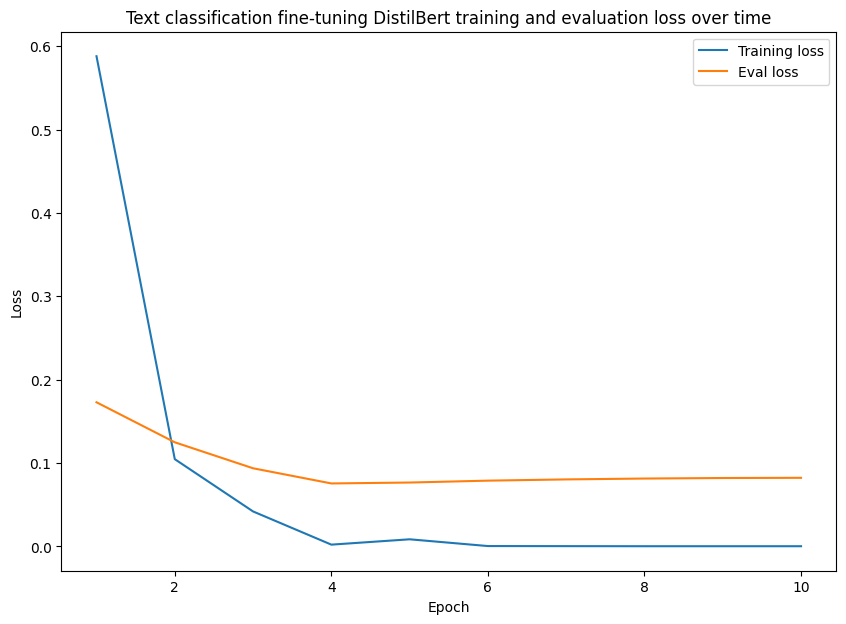

In [ ]:
# Plot the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(trainer_history_train_df["epoch"], trainer_history_train_df["loss"], label = "Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification fine-tuning DistilBert training and evaluation loss over time")
plt.legend()
plt.show()

### Pushing our model to the Hugging Face Hub

Why do this?

So we can share our model.

Other people can try it out.

We can keep history of different model versions

To save to the Hugging Face Hub, we can use the `Trainer.push_to_hub` method


In [ ]:
# Save our model to the Hugging Face Hub
model_upload_url = trainer.push_to_hub(
    commit_message =  "Sbudo text classifier"
)

print(f"Model successfully uploaded to the Hugging Face Hub with URL: {model_upload_url}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Model successfully uploaded to the Hugging Face Hub with URL: https://huggingface.co/Sairii/comida_no_comida_text_classifier/tree/main/


### Making and evaluating predictions on the test data

Evaluating a model is just as important as training a model.

We can make predictions on the test data using the `Trainer.predict`

In [ ]:
# Perfom predictions on the test data
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
predictions_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
predictions_metrics

[INFO] Prediction metrics on the test data:


{'test_loss': 0.07558247447013855,
 'test_accuracy': 0.9903381642512077,
 'test_runtime': 8.0669,
 'test_samples_per_second': 25.66,
 'test_steps_per_second': 0.868}

> **Note:** If you want a good evaluation method, make predictions on your entire test dataset, then index on the prediction which are wrong but have high prediction probabilty.

For example, get the top 100-1000 and go through all of the examples where the model's prediction had high probabilitye but was incorrect -> this often lead to great insights into your data.

### Let's get prediction probabilities and evaluate by hand

In [ ]:
# Predicted logits (raw output of the model) -> prediction probabilities with torch.softmax -> predicted labels
import torch
from sklearn.metrics import accuracy_score

# 1. Get predictions probabilites with torch.softmax
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)

# 2. Get predicted labels
pred_labels = torch.argmax(pred_probs, axis=1)

# 3. Get the true labels
true_labels = tokenized_dataset["test"]["label"]

# 4. Compute prediction labels to true labels and get the test accuracy
test_accuracy = accuracy_score(y_true= true_labels,
                              y_pred = pred_labels)

# 3. Get the true labels
true_labels = tokenized_dataset["test"]["label"]

# 4. Compute prediction labels to true labels and get the test accuracy
test_accuracy = accuracy_score(y_true= true_labels,
                              y_pred = pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}%")

[INFO] Test accuracy: 99.03381642512076%


### Exploring our models prediction probabilites

It's a very good way to evaluate a model by sorting prediction probabilites and seeing where the model went wrong.

In [ ]:
# Make a dataframe of test predictions
test_predictions_df= pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label" : true_labels,
    "pred_label" : pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df

,text,true_label,pred_label,pred_prob
0,Todo lo que necesitas ya está dentro de ti.,0,0,0.998863
1,"Pasta con crema de trufa, una experiencia lujo...",1,1,0.999532
2,Las palabras pueden ser más poderosas que cual...,0,0,0.998809
3,Los rábanos encurtidos son un acompañamiento v...,1,1,0.999577
4,Un plato de arroz con pollo siempre trae recue...,1,1,0.999564
...,...,...,...,...
202,Nada como las costillas al horno con una salsa...,1,1,0.999586
203,Un curry de mariscos bien hecho es un manjar i...,1,1,0.999547
204,La longaniza es una de las grandes protagonist...,1,1,0.999214
205,Nada se siente tan bien como un abrazo sincero.,0,1,0.999440


In [ ]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
109,La panceta es el ingrediente secreto que da vi...,1,1,0.634474
8,Un día sin preocupaciones es un día lleno de p...,0,0,0.960879
191,Las mejores decisiones son las que se toman co...,0,0,0.995417
160,Las cosas buenas vienen a aquellos que no se r...,0,0,0.996830
102,La papaya es ideal para la digestión y llena d...,1,1,0.997112
76,Las dificultades son oportunidades disfrazadas.,0,0,0.997455
110,Una buena lasaña tiene capas de amor y queso d...,1,1,0.997604
133,El cielo azul parece más brillante cuando lo m...,0,0,0.998108
53,El cielo azul parece más brillante cuando lo m...,0,0,0.998108
197,El cielo azul parece más brillante cuando lo m...,0,0,0.998108


## 6. Making and inspecting predictions on custom text data

### Discussing ways to make predictions (inference)

* Note: Whenever you hear the word "inference" it means to use a model to make predictions on data.

Two main ways to perfom inference:

1. **Pipeline mode** - Using `transfomers.pipeline` to load our model and perform text classification.

2. **PyTorch mode** - Using a combination of `transformers.AutoTokenizer` and `transformers.AutoModelForSequenceClassification` and passing each our target model name.

Each mode supports:

1. Predictions one at a time (fast but can be slower with many many samples).
 * Helpul for a say a comment system and comments happen spordicaly, to predict wheter the comment was "spam" or "not spam".
2. Batches or predictions at a time (faster but up to a point).
 * Helpful for when you have a large static database or many samples coming in at once.

In [ ]:
# Setup our device for making predictions
# Note: generally the faster the hardware acceleator, the faster the predictions
# For example if you have a dedicated GPU, you should use it over CPU

def set_device():
  if torch.cuda.is_available():
    device = torch.device("cuda")
  elif torch.backends.mps.is_available() and torch.backneds.mps.is_built():
    device = torch.device("mps")
  else:
    device = torch.device("cpu")
  return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cpu


In [ ]:
local_model_path = "/content/models/comida_no_comida_text_classifier"

huggingface_model_path="Sairii/comida_no_comida_text_classifier"

### Making predictions with pipeline mode

In [ ]:
import torch
from transformers import pipeline

# Set batch size
BATCH_SIZE = 32

# create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model = local_model_path,
                                    device = DEVICE,
                                    top_k = 1,
                                    batch_size = BATCH_SIZE)

food_not_food_classifier

Device set to use cpu


In [ ]:
test_custom_sentence = "Un plato de frutas"
food_not_food_classifier(test_custom_sentence)

[[{'label': 'comida', 'score': 0.9994280934333801}]]

In [ ]:
test_no_food_sentence = "Un coche del 2020"
food_not_food_classifier(test_no_food_sentence)

[[{'label': 'comida', 'score': 0.7993609309196472}]]

In [ ]:
# Use pipeline with a model from Hugging face
food_not_food_classifier = pipeline(task = "text-classification",
                                    model = huggingface_model_path,
                                    device=DEVICE,
                                    top_k=1,
                                    batch_size=BATCH_SIZE)

food_not_food_classifier(test_no_food_sentence)

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


[[{'label': 'comida', 'score': 0.7993609309196472}]]

### Making multiple predictions at the same time with batch prediction

In [ ]:
# Create a list of sentences to make predictions on
sentences = [
    "Las estrellas en el cielo nos recuerdan lo pequeños que somos en el universo.",
    "Un buen libro puede transportarte a mundos que nunca imaginaste.",
    "El sonido de la lluvia golpeando la ventana es una melodía para el alma.",
    "Nada como la brisa del mar para sentirte libre por un momento.",
    "Las palabras tienen el poder de sanar o destruir, elige bien las tuyas.",
    "Los abrazos sinceros son el mejor refugio en los días difíciles.",
    "La música tiene la capacidad de revivir recuerdos con solo unas notas.",
    "El tiempo es el recurso más valioso que tenemos, úsalo sabiamente.",
    "Las montañas nos enseñan que lo mejor siempre está en la cima.",
    "La creatividad es el motor que impulsa el cambio en el mundo."

]

food_not_food_classifier(sentences)

[[{'label': 'comida', 'score': 0.7715104818344116}],
 [{'label': 'no_comida', 'score': 0.9985836744308472}],
 [{'label': 'no_comida', 'score': 0.9967603087425232}],
 [{'label': 'no_comida', 'score': 0.9983289837837219}],
 [{'label': 'no_comida', 'score': 0.9985772371292114}],
 [{'label': 'comida', 'score': 0.999525785446167}],
 [{'label': 'no_comida', 'score': 0.9986562728881836}],
 [{'label': 'no_comida', 'score': 0.9981988072395325}],
 [{'label': 'comida', 'score': 0.9983933568000793}],
 [{'label': 'comida', 'score': 0.6452469229698181}]]

In [ ]:
food_captions = [
    "Nada como el aroma del pan recién horneado en la mañana.",
    "Un buen plato de pasta puede arreglar cualquier día.",
    "El chocolate derretido es la definición de felicidad en estado líquido.",
    "Las frutas frescas son como pequeños regalos de la naturaleza.",
    "No hay mejor compañía para una película que unas palomitas de maíz crujientes.",
    "El queso fundido mejora cualquier comida, sin excepción.",
    "Una taza de café caliente es el mejor comienzo para cualquier jornada.",
    "El sushi es una obra de arte hecha de arroz y pescado.",
    "Las especias pueden transformar un plato simple en una experiencia inolvidable.",
    "Un buen postre es el final perfecto para cualquier comida."
]

not_food_captions = [
     "El sonido de las olas rompiendo en la orilla es pura paz.",
    "Un buen libro es una puerta a infinitas aventuras.",
    "Las estrellas nos recuerdan lo vasto que es el universo.",
    "La música tiene el poder de transportarnos a otro tiempo y lugar.",
    "Nada como una caminata bajo la lluvia para aclarar la mente.",
    "Los abrazos son la mejor medicina para el alma.",
    "El arte es la forma más pura de expresar lo que sentimos.",
    "Cada amanecer nos da una nueva oportunidad para empezar de nuevo.",
    "La fotografía nos permite capturar momentos que nunca volverán.",
    "El tiempo es el recurso más valioso que tenemos, úsalo sabiamente."
]


In [ ]:
food_not_food_classifier(food_captions)

[[{'label': 'comida', 'score': 0.9991150498390198}],
 [{'label': 'comida', 'score': 0.9995152950286865}],
 [{'label': 'comida', 'score': 0.9993361830711365}],
 [{'label': 'comida', 'score': 0.9993901252746582}],
 [{'label': 'comida', 'score': 0.9994667172431946}],
 [{'label': 'comida', 'score': 0.9993958473205566}],
 [{'label': 'comida', 'score': 0.9992075562477112}],
 [{'label': 'comida', 'score': 0.9995540976524353}],
 [{'label': 'comida', 'score': 0.9993773102760315}],
 [{'label': 'no_comida', 'score': 0.5275015234947205}]]

In [ ]:

food_not_food_classifier(not_food_captions)

[[{'label': 'no_comida', 'score': 0.9667540192604065}],
 [{'label': 'comida', 'score': 0.9351096749305725}],
 [{'label': 'comida', 'score': 0.8223812580108643}],
 [{'label': 'no_comida', 'score': 0.998672366142273}],
 [{'label': 'comida', 'score': 0.5468019843101501}],
 [{'label': 'comida', 'score': 0.9994600415229797}],
 [{'label': 'no_comida', 'score': 0.9986706972122192}],
 [{'label': 'no_comida', 'score': 0.9988369345664978}],
 [{'label': 'no_comida', 'score': 0.998699426651001}],
 [{'label': 'no_comida', 'score': 0.9981988072395325}]]

In [ ]:
confusing_captions = [
   "El sonido de las olas rompiendo en la orilla es pura paz.",
    "Un buen libro es una puerta a infinitas aventuras.",
    "Las estrellas nos recuerdan lo vasto que es el universo.",
    "La música tiene el poder de transportarnos a otro tiempo y lugar.",
    "Nada como una caminata bajo la lluvia para aclarar la mente.",
    "Los abrazos son la mejor medicina para el alma.",
    "El arte es la forma más pura de expresar lo que sentimos.",
    "Cada amanecer nos da una nueva oportunidad para empezar de nuevo.",
    "La fotografía nos permite capturar momentos que nunca volverán.",
    "El tiempo es el recurso más valioso que tenemos, úsalo sabiamente."
]

food_not_food_classifier(confusing_captions)

[[{'label': 'no_comida', 'score': 0.9667540192604065}],
 [{'label': 'comida', 'score': 0.9351096749305725}],
 [{'label': 'comida', 'score': 0.8223812580108643}],
 [{'label': 'no_comida', 'score': 0.998672366142273}],
 [{'label': 'comida', 'score': 0.5468019843101501}],
 [{'label': 'comida', 'score': 0.9994600415229797}],
 [{'label': 'no_comida', 'score': 0.9986706972122192}],
 [{'label': 'no_comida', 'score': 0.9988369345664978}],
 [{'label': 'no_comida', 'score': 0.998699426651001}],
 [{'label': 'no_comida', 'score': 0.9981988072395325}]]

### Time our model accros larger sample sizes

In [ ]:
import time

# Create 1000 sentences
sentences_1000 = sentences * 100

# Time how long it takes to make predictions on all sentences (one at a time)
print(f"[INFO] Number of sentences: {len(sentences_1000)}")
start_time_one_at_a_time = time.time()
for sentence in sentences_1000:
  # Make a prediction
  food_not_food_classifier(sentence)
end_time_one_at_a_time  = time.time()

total_time_one_at_a_time = end_time_one_at_a_time  - start_time_one_at_a_time
avg_time_per_pred = total_time_one_at_a_time / len(sentences_1000)
print(f"[INFO] Total time for making predicions on {len(sentences_1000)}: {total_time_one_at_a_time}s")

print(f"[INFO] Avg time per prediction:{avg_time_per_pred}s ")

[INFO] Number of sentences: 1000
[INFO] Total time for making predicions on 1000: 46.253424406051636s
[INFO] Avg time per prediction:0.04625342440605164s 


In [ ]:

# Let's now use piplein in batches
for i in [10, 100, 1000, 10000]:
  sentences_big = sentences * i
  print(f"[INFO] Number of sentences: {len(sentences_big)}")

  start_time = time.time()
  # Predict on all setences in batch model
  food_not_food_classifier(sentences_big)
  end_time = time.time()

  total_time_per_all_sentences = end_time - start_time
  avg_time_per_sentence = total_time_per_all_sentences / len(sentences_big)
  print(f"[INFO] Inferece time for {len(sentences_big)} sentences: {round(total_time_one_at_a_time,6)}s")
  print(f"[INFO] Avg inference time per sentence: {round(avg_time_per_sentence,8)}s")

[INFO] Number of sentences: 100
[INFO] Inferece time for 100 sentences: 46.253424s
[INFO] Avg inference time per sentence: 0.02710322s
[INFO] Number of sentences: 1000
[INFO] Inferece time for 1000 sentences: 46.253424s
[INFO] Avg inference time per sentence: 0.02731604s
[INFO] Number of sentences: 10000
[INFO] Inferece time for 10000 sentences: 46.253424s
[INFO] Avg inference time per sentence: 0.02770849s
[INFO] Number of sentences: 100000


### Making predictions with PyTorch

Steps with PyTorch predictions:

1. Create the tokenizer with `AutoTokenizer`.
2. Create the model with `AutoModel` (`AutoModelForSequenceClassification`)
3. Tokenize text with 1
4. Make predictions with 2
5. Format predictions

In [ ]:
from transformers import AutoTokenizer

# Setup the model path
model_path = "Sairii/comida_no_comida_text_classifier"

# Create an example to predict on
sample_food_text = "Un delicioso plato de huevos, con beicon y patatas"
# Prepare the tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
inputs = tokenizer(sample_food_text,
                   return_tensors = "pt")
inputs

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load our text classification model
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model

In [ ]:
import torch

model.eval()
with torch.inference_mode():
  outputs = model(**inputs) #"**" means input all of the diccitionary keys as named arguments
  outputs_verbose = model(input_ids = inputs["input_ids"],
                          attention_mask = inputs["attention_mask"])
outputs

In [ ]:
outputs_verbose

In [ ]:
# Convert logits to prediction probability  + labels
output_logits = outputs.logits
predicted_class_id = outputs.logits.argmax().item()
predicted_class_label = model.config.id2label[predicted_class_id]
predicted_probability = torch.softmax(outputs.logits,dim = 1).max().item()

print(f"Text: {food_captions}")
print(f"Predicted class: {predicted_class_label} (prob: {predicted_probability * 100:.2f}%)")

## 7. Turning our model into a demo

Turning a model into a demo helps you share it with others so they can try it out.

And can potentially shaed some insights into how our model could be improved.

We're going to create a machine learning model demo with Gradio: https://www.gradio.app/

### Creating a simple function to perform inference

1. Take an input of string
2. Setup a text classification pipeline
3. Get the output from the piplein
4. Return the output from the pipleine in stpe 3 as formatted dictionary with the format: `{"label_1": probability_1, "label_2": probability_2}`

In [ ]:
from typing import Dict

# 1. Create a function to take a string input
def food_not_food_classifier(text: str) -> Dict[str, float]:
  # 2. Setup food not food text classifier
  food_not_food_classifier_pipeline= pipeline(task="text-classification",
                                     model=local_model_path,
                                     batch_size = 32,
                                     device="cuda" if torch.cuda.is_available() else "cpu",
                                     top_k = None) # return all possible labels

  # 3. GEt the outputs from our pipeline
  outputs = food_not_food_classifier_pipeline(text)[0]

  # 4. Format ouput for Gradio
  output_dict = {}
  for item in outputs:
    output_dict[item["label"]] = item["score"]

  return output_dict


food_not_food_classifier(text = "You are building a demo!")

### Build a small Gradio demo to run locally

In [ ]:
# 1. Import gradio
import gradio as gr

# 2. Create a gradio interface https://www.gradio.app/main/docs/gradio/interface#demos
demo = gr.Interface(
    fn = food_not_food_classifier,
    inputs = "text",
    outputs = gr.Label(num_top_classes=2),
    title="Comida No Comida ",
    description = "Un classificador de texto que te indica si la frase es sobre comida o no",
    examples =[["Me gusta ver la nieve caer por la ventana"],
               ["Un plato de huevos con patatas"]]

)

# 3. Launch the interface
demo.launch()


## 8. Making our demo publicly accessible

There are two main ways to make our demo accesibl with Hugging Face Spaces:

1. Manually - We can go to huggingface.co/spaces -> "Create new space" -> add our files and publish!

2. Programmatically - We can use the Hugging Face Hub Python API and add our files to a Space with code.

To create a Space programmatically we're going to create three files:

1. `app.py` - This is the main app with funtionality of our demo.
2. `requirements.txt` - These are the dependecie which our app will require
3. `README.md` - This will explain what our project/demo is about. And will also add some metada in YAML format.

To create these we'll use the following file structure:
```
demos/
└── food_not_food_text_classifier/
    ├── app.py
    ├── README.md
    └── requirements.txt

```


### Making a directory to store our demo

In [ ]:
from pathlib import Path

# Make directory for demos
demos_dir = Path("../demos")
demos_dir.mkdir(exist_ok=True)

# Create a folder for the food_not_foot_text_classifier demo
food_not_food_text_classifier_demo_dir = Path(demos_dir, "food_not_food_text_classifier")
food_not_food_text_classifier_demo_dir.mkdir(exist_ok=True)

### Making an app.py file

Our `app.py` will contain the main logic of our application to run

When we upload it to Hugging Face Spaces, Spaces will try to run `app.py` automatically.

In our `app.py` file we want to:

1. Import packages.
2. Define our function to use our model (this will work with Gradio)
3. Create a demo with Gradio
4. Run the demo with demo.launch()

To create each of or files, we're going to use the magic command %%writefile


In [ ]:
%%writefile ../demos/food_not_food_text_classifier/app.py
# 1.Import the requiere files
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# 2. Define our function to use with our model
def food_not_food_classifier(text: str) -> Dict[str, float]:
  # 2. Setup food not food text classifier
  food_not_food_classifier_pipeline= pipeline(task="text-classification",
                                     model="Sairii/comida_no_comida_text_classifier",
                                     batch_size = 32,
                                     device="cuda" if torch.cuda.is_available() else "cpu",
                                     top_k = None) # return all possible labels

  # 3. GEt the outputs from our pipeline
  outputs = food_not_food_classifier_pipeline(text)[0]

  # 4. Format ouput for Gradio
  output_dict = {}
  for item in outputs:
    output_dict[item["label"]] = item["score"]

  return output_dict

# 3. Create a gradio interface
description = """
Un classificador de texto que te indica si la frase es sobre comida o no.
"""

demo = gr.Interface(
    fn = food_not_food_classifier,
    inputs = "text",
    outputs = gr.Label(num_top_classes=2),
    title = "🥘🐔🍔🚫 Clasificador de Comida o No Comida",
    description = description,
    examples = [["Me gusta ver la nieve caer por la ventana"],
               ["Un plato de huevos con patatas"]]

)

# 4.Launch the interfeace
if __name__ == "__main__":
  demo.launch()

🥘🐔🍔🚫

### Making a README file

This file is in markdown format.

With a special YAML block at the top.

The YAML block at the top is used for metada + settings.

In [ ]:
%%writefile ../demos/food_not_food_text_classifier/README.md
---
title: Clasificador de Texto sobre Comida o No Comida
emoji: 🥘🐔🍔🚫
colorFrom: blue
colorTo: yellow
sdk: gradio
app_file: app.py
pinned: false
licence: apache-2.0
---

# 🥘🐔🍔🚫 Clasificador de Comida o No Comida


Pequeña demo para ver un clasificador de texto que determina si una frase es sobre comida o no.

DistilBERT model fine-tuned en un dataset con [995 capturas sobre comida/no_comida](https://huggingface.co/datasets/Sairii/comida_no_comida)


### Making a requirements file

This file is going to tell our Hugging Face Space wich version/which packages to use.

If we don't create this file, we may get an error such as:

===== Application Startup at 2024-06-13 05:37:21 =====

Traceback (most recent call last):
  File "/home/user/app/app.py", line 1, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'

In [ ]:
%%writefile ../demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

### Uploading our demo to Hugging Face Spaces

To do so, we'll use the Hugging FAce Hub Python API - https://huggingface.co/docs/huggingface_hub/en/package_reference/hf_api

To get our demo hosted on Hugging Face Spaces we’ll go through the following steps:

1. Import the required methods from the huggingface_hub package, including `create_repo`, `get_full_repo_name`, `upload_file` (optional, we’ll be using `upload_folder`) and upload_folder.
2. Define the demo folder we’d like to upload as well as the different parameters for the Hugging Face Space such as repo type ("space"), our target Space name, the target Space SDK ("gradio"), our Hugging Face token with write access (optional if it already isn’t setup).
3. Create a repository on Hugging Face Spaces using the `huggingface_hub.create_repo` method and filling out the appropriate parameters.
4. Get the full name of our created repository using the `huggingface_hub.get_full_repo_name` method (we could hard code this but I like to get it programmatically incase things change).
5. Upload the contents of our target demo folder (`../demos/food_not_food_text_classifier/`) to Hugging Face Hub with `huggingface_hub.upload_folder`.
6. Hope it all works and inspect the results! 🤞

In [ ]:
# 1. Import the required methods for uploading to the HF Hub
from huggingface_hub import(
    create_repo,
    get_full_repo_name,
    upload_file,
    upload_folder
)

# 2. Define the parameters we'd like to use for uploading our Space
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD ="../demos/food_not_food_text_classifier"
HF_TARGET_SPACE_NAME = "learn_hf_food_not_food_text_classifier_demo"
HF_REPO_TYPE = "space"
HF_SPACE_SDK="gradio"

# 3. Create a Space repo on Hugging Face Hub
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    repo_type = HF_REPO_TYPE,
    private=False,
    space_sdk = HF_SPACE_SDK,
    exist_ok = True

)

# 4. Get the full repo name(e.g. {username}/{repo_name})
hf_full_repo_name = get_full_repo_name(model_id = HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {hf_full_repo_name}")

# 5.Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo:{hf_full_repo_name}")
folder_upload_url = upload_folder(
    repo_id = hf_full_repo_name,
    folder_path = LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo = ".",
    repo_type=HF_REPO_TYPE,
    commit_message = "Uploading our foot not food text classifier demos from  a notebook"

)

print(f"[INFO] Demo folder successfully with commit URL: {folder_upload_url} ")